energy:(Hartree) 0.19456813255353836


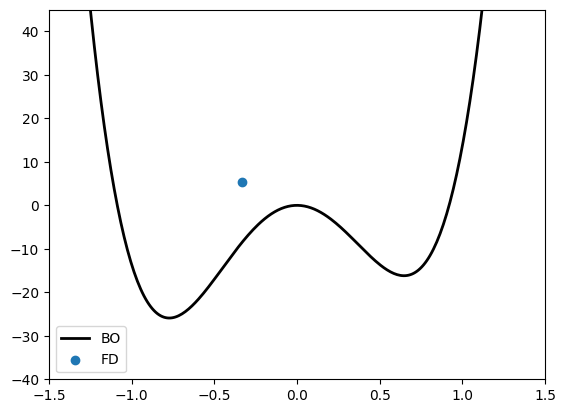

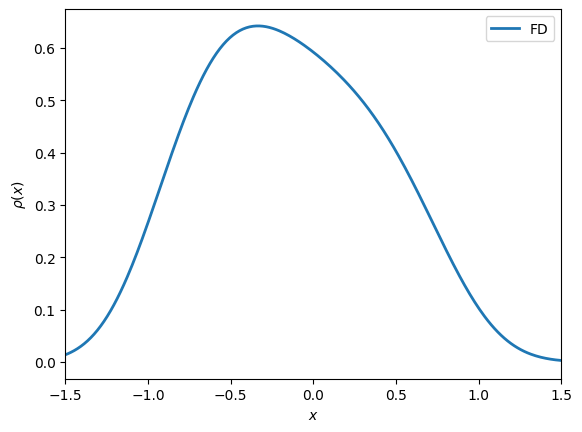

Excitation Energies:(Hartree)
[ 0.19456813  1.73513997  4.54932271  7.82492991 11.54729191 15.62874664]


In [1]:
import numpy as np 
from scipy.linalg import eigh 

#mesh of the finite difference 
xmin = -10; xmax = 10; Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh)
h = xmesh[1] - xmesh[0]

def Vpot(x):
    return 3*x**4 + x**3/2 - 3*x**2
    
def buildH():
    Vx = np.array([Vpot(x) for x in xmesh])
    H = np.diag(Vx) 

    for i in range(Nmesh):
        H[i, i] += 1./(h*h)

    for i in range(Nmesh-1):
        H[i, i+1] += -0.5/(h*h)
        H[i+1, i] += -0.5/(h*h)
    
    return H 

if __name__=='__main__':

    hartree2ev = 27.2107
    H = buildH()
    w, v = eigh(H)
    gs_wf = v[:,0]
    normalize_factor = (gs_wf**2).sum() * h
    # rescale to probability amplitude
    gs = gs_wf**2 / normalize_factor
    
    nlowest = 1
    print ('energy:(Hartree)', w[0])

    import matplotlib.pyplot as plt

    xmes_argmax = gs.argmax()
    plt.plot(xmesh, [Vpot(x)*hartree2ev for x in xmesh], 'k-', lw=2, label="BO")
    plt.scatter(xmesh[xmes_argmax], w[0:nlowest]*hartree2ev,label="FD")
    plt.xlim([-1.5,1.5])
    plt.ylim([-40,45])
    plt.legend()
    plt.show()

    plt.plot(xmesh, gs, label='FD', lw=2)
    plt.xlim([-1.5,1.5])
    plt.xlabel('$x$')
    plt.ylabel(r'$\rho(x)$')
    plt.legend()
    plt.show()

    print("Excitation Energies:(Hartree)")
    num_of_orbs = 5
    print(f"{w[:6:]}")